In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud

2024-05-06 06:27:56.467302: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 06:27:56.467432: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 06:27:56.607165: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
training_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
testing_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
training_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
training_data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [4]:
testing_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
testing_data.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [6]:
training_data.shape , testing_data.shape

((7613, 5), (3263, 4))

# **Exploratory Data Analysis**

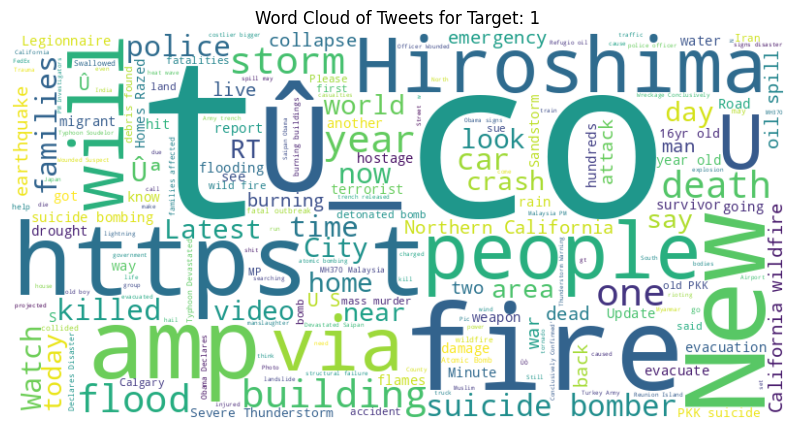

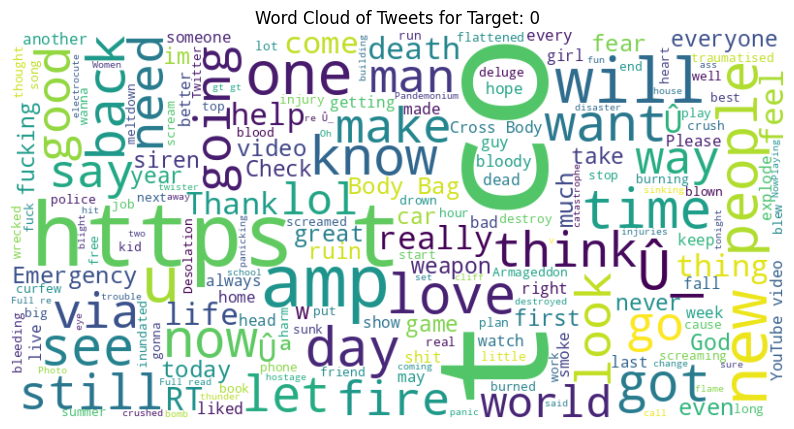

In [7]:
# Assuming train_data has a column named 'target' containing the target categories
targets = training_data['target'].unique()

# Generate word cloud for each target category
for target in targets:
    # Concatenate text for the current target category
    text_combined = " ".join(text for text in training_data[training_data['target'] == target]['text'])
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

    # Display word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Tweets for Target: ' + str(target))
    plt.show()

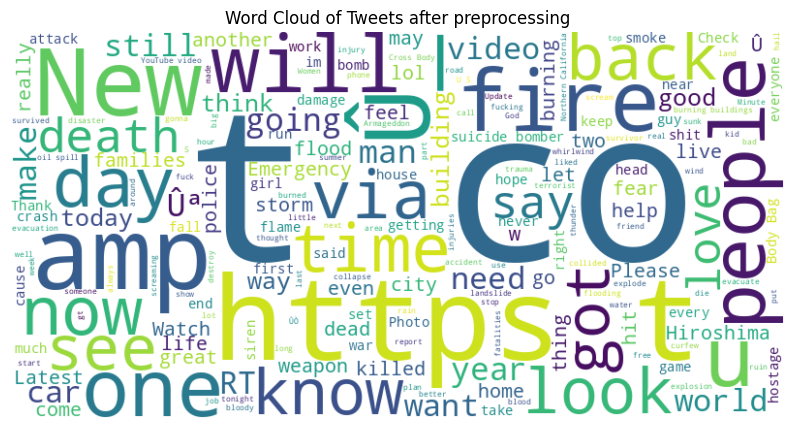

In [8]:
text_combined = " ".join(text for text in training_data.text)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets after preprocessing')
plt.show()

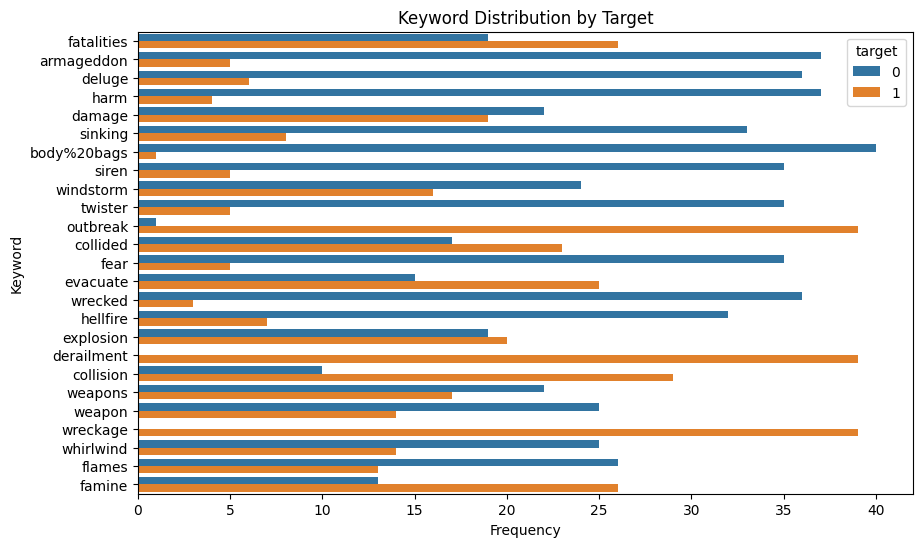

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(y='keyword', hue='target', data=training_data, order=training_data['keyword'].value_counts().iloc[:25].index)
plt.title('Keyword Distribution by Target')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()

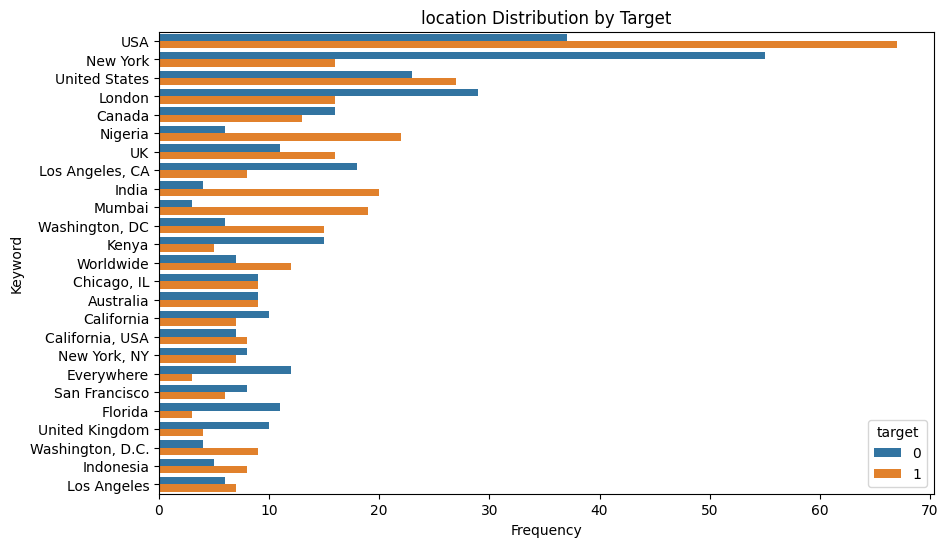

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(y='location', hue='target', data=training_data, order=training_data['location'].value_counts().iloc[:25].index)
plt.title('location Distribution by Target')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()

<Axes: xlabel='count', ylabel='keyword'>

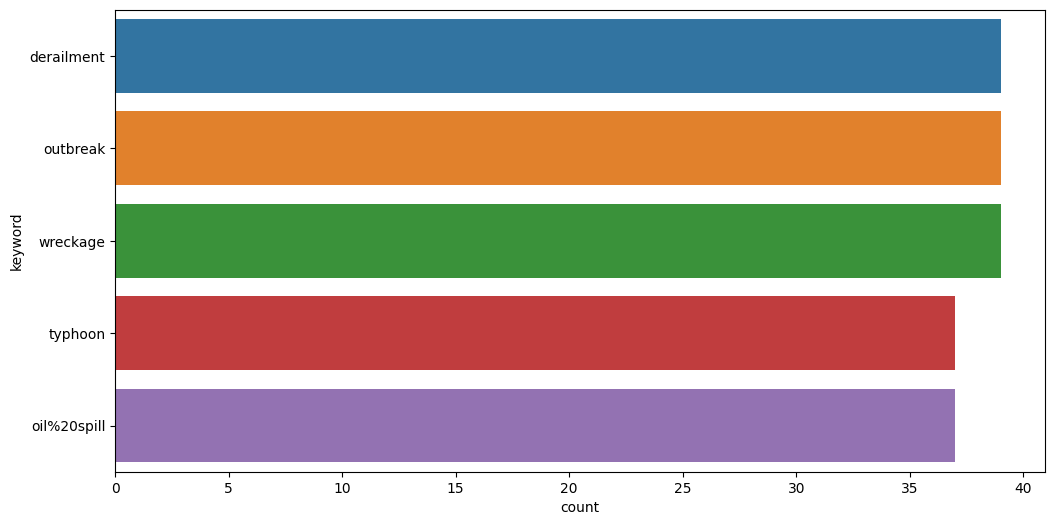

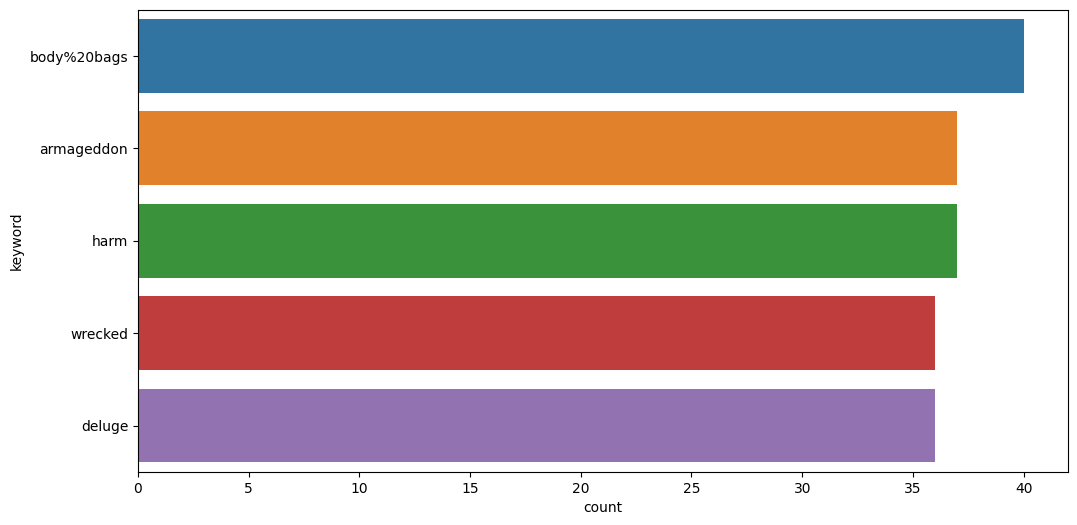

In [11]:
disaster = training_data.loc[training_data['target'] == 1]["keyword"].value_counts()
fig,axes1 = plt.subplots(figsize=(12,6))
sns.barplot(x=disaster[0:5],y = disaster[0:5].index)
not_disaster = training_data.loc[training_data['target'] == 0]["keyword"].value_counts()
fig,axes2 = plt.subplots(figsize=(12,6))
sns.barplot(x=not_disaster[0:5],y = not_disaster[0:5].index)

# **Model**

In [12]:
messages = training_data.copy()
messages.reset_index(inplace=True)
stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
corpus = []
for i in range(0,len(messages)):
    review = re.sub('[^a-zA-Z0-9]',' ',messages['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [stemmer.stem(words) for words in review if not words in stopwords]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
vocabulary_size = 5000
sentence_length =15
one_hot_representation = [one_hot(words,vocabulary_size)for words in corpus]
one_hot_representation[1]

[2014, 4614, 1503, 1599, 1889, 629, 234]

In [14]:
padding = pad_sequences(one_hot_representation,maxlen=sentence_length , padding='pre')
padding[1]

array([   0,    0,    0,    0,    0,    0,    0,    0, 2014, 4614, 1503,
       1599, 1889,  629,  234], dtype=int32)

In [15]:
embedded_vector = 40
model = Sequential()
model.add(Embedding(vocabulary_size,embedded_vector,input_shape=(sentence_length,)))
model.add(Dropout(0.2))
model.add((LSTM(200)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 15, 40)         │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200)            │       192,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393,001 (1.50 MB)

 Trainable params: 393,001 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics =['accuracy'])

In [17]:
y = training_data['target']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [18]:
X_final = np.array(padding)
y_final = np.array(y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

In [20]:
earlystopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [21]:
Model= model.fit(X_final,y_final,validation_data=(X_test,y_test),epochs=15,batch_size=32)

Epoch 1/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6504 - loss: 0.6069 - val_accuracy: 0.8628 - val_loss: 0.3540
Epoch 2/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8400 - loss: 0.3797 - val_accuracy: 0.8949 - val_loss: 0.2845
Epoch 3/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8766 - loss: 0.3151 - val_accuracy: 0.9166 - val_loss: 0.2423
Epoch 4/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9053 - loss: 0.2413 - val_accuracy: 0.9389 - val_loss: 0.1703
Epoch 5/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9322 - loss: 0.1868 - val_accuracy: 0.9521 - val_loss: 0.1385
Epoch 6/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9434 - loss: 0.1456 - val_accuracy: 0.9718 - val_loss: 0.1019
Epoch 7/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9627 - loss: 0.1103 - val_accuracy: 0.9705 - val_loss: 0.0730
Epoch 8/15
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9708 - loss: 0.0898 - val_accuracy: 0.

In [22]:
Model.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

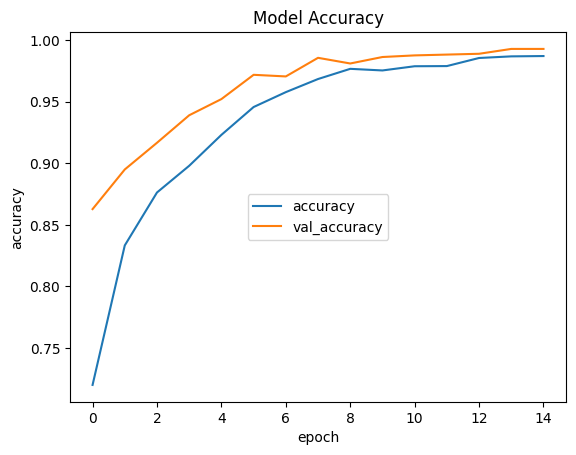

In [23]:
plt.plot(Model.history['accuracy'])
plt.plot(Model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy','val_accuracy'],loc='center')
plt.show()

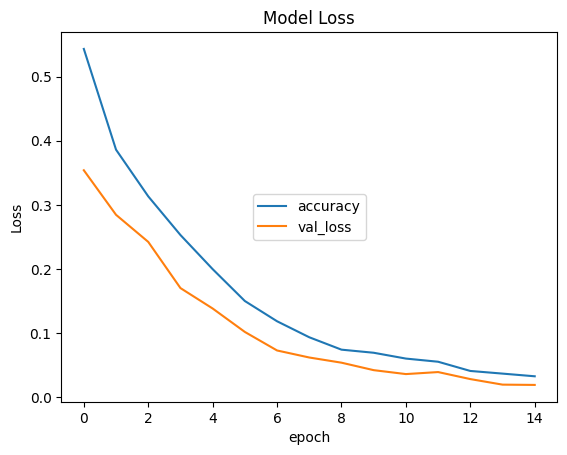

In [24]:
plt.plot(Model.history['loss'])
plt.plot(Model.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['accuracy','val_loss'],loc='center')
plt.show()

# **Predictions**

In [25]:
messages = testing_data['text']

In [26]:
corpus = []
for i in range(0,len(messages)):
    review = re.sub('[^a-zA-Z0-9]',' ',messages[i])
    review = review.lower()
    review = review.split()
    
    review = [stemmer.stem(words) for words in review if not words in stopwords]
    review = ' '.join(review)
    corpus.append(review)

In [27]:
corpus[0]

'happen terribl car crash'

In [28]:
one_hot_representation = [one_hot(words,vocabulary_size)for words in corpus]
padding1 = pad_sequences(one_hot_representation,maxlen=sentence_length , padding='pre')
X_test = np.array(padding1)

In [29]:
prediction = model.predict(X_test)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [30]:
val=[]
for i in prediction:
    val.append(i[0])

In [31]:
final_target = np.round(val).astype(int)
len(final_target)

3263

# **Submission**

In [32]:
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission.head() , submission.shape
submission_id = submission['id']
submission_id

0           0
1           2
2           3
3           9
4          11
        ...  
3258    10861
3259    10865
3260    10868
3261    10874
3262    10875
Name: id, Length: 3263, dtype: int64

In [33]:
submission = pd.DataFrame({'id': submission_id, 'target':final_target})
submission.to_csv('submission.csv', index=False)